This Jupyter notebook contains the GNNExplainer method.

In [44]:
import pandas as pd
import networkx as nx
import numpy as np
import torch

import pickle
import copy

import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

In [2]:
dataset_nr = 1

# Load all data

Load the nodes

In [3]:
nodes = pd.read_csv(f'output/indexed_nodes_{dataset_nr}.csv')
nodes

,index_id,id,semantic,label,semantic_id
0,0,WormBase:WBGene00000389,ORTH,cdc-25.4,5
1,1,ZP:0018675,DISO,right side lateral plate mesoderm mislocalised...,1
2,2,ZFIN:ZDB-GENE-040426-1197,ORTH,tbc1d5,5
3,3,5,DRUG,(S)-nicardipine,2
4,4,RGD:3443,ORTH,Ptk2,5
...,...,...,...,...,...
10029,10029,MP:0009763,DISO,increased sensitivity to induced morbidity/mor...,1
10030,10030,MP:0011057,DISO,absent brain ependyma motile cilia,1
10031,10031,MP:0001412,DISO,excessive scratching,1
10032,10032,WBPhenotype:0004023,DISO,frequency of body bend variant,1


Load the Edge2Vec embedding

In [4]:
node_feat = KeyedVectors.load(f'output/w2v_{dataset_nr}.dvectors', mmap='r')

e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
for idx, key in enumerate(node_feat.index_to_key):
    e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})
    
e2v_embedding = e2v_embedding.sort_values('Node')
e2v_embedding

,Node,Embedding
0,0,"[0.23430845, -0.22153802, 0.29080248, 0.153929..."
1,1,"[0.23548242, -0.19628452, 0.3288001, 0.1936409..."
2,2,"[0.19008121, -0.37460387, 0.43780017, 0.141685..."
3,3,"[0.19433619, -0.21838334, 0.260041, 0.19633888..."
4,4,"[0.4364385, -0.48848882, 0.2483637, 0.44575173..."
...,...,...
10029,10029,"[0.3179047, -0.36064115, 0.32512513, 0.3515173..."
10030,10030,"[0.17949638, -0.20491056, 0.2284929, 0.1872862..."
10031,10031,"[0.32319647, -0.32017368, 0.3412019, 0.3066842..."
10032,10032,"[0.43276545, -0.1972076, 0.46449026, 0.1191806..."


Load the edges

In [5]:
edges = pd.read_csv(f'output/indexed_edges_{dataset_nr}.csv')
edges

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
0,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,FlyBase:FBgn0085464,CG34435,5,6825,0
1,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,HGNC:7585,MYL4,3,27,0
2,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,FlyBase:FBgn0002772,Mlc1,5,8901,0
3,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,NCBIGene:396472,MYL4,3,9508,0
4,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in 1 to 1 orthology relationship with,ENSEMBL:ENSECAG00000020967,ENSEMBL:ENSECAG00000020967,5,8807,1
...,...,...,...,...,...,...,...,...,...,...
82908,4810,ibrutinib,2,1618,targets,HGNC:11283,SRC,3,3279,14
82909,522,carvedilol,2,184,targets,HGNC:620,APP,3,547,14
82910,OMIM:300377.0013,"DMD, EX18DEL",1,2822,is allele of,HGNC:2928,DMD,3,6612,16
82911,Coriell:GM05113,NIGMS-GM05113,4,8105,has role in modeling,MONDO:0010679,Duchenne muscular dystrophy,1,6315,15


Initialize a graph with edges and nodes including the embedding features of each node.

In [6]:
G = nx.Graph() # TODO: DiGraph?
for ind, node in e2v_embedding.iterrows(): 
    G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edges.iterrows(): 
    G.add_edge(int(edge['index_head']), int(edge['index_tail']), edge_label = edge['relation'])
  
for node in G.nodes(data=True):
    print(node)
    break
for edge in G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(G.number_of_edges()))
print("Number of nodes is {}".format(G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.2343, -0.2215,  0.2908,  0.1539,  0.2281, -0.6121, -0.1702, -0.1491,
        -0.3883, -0.1492,  0.1752, -0.0812,  0.1012, -0.3064,  0.2251,  0.1858,
        -0.1671,  0.2798, -0.2372,  0.6207,  0.5475,  0.2320,  0.2394, -0.2868,
        -0.1666,  0.2079, -0.4518, -0.1384,  0.1306, -0.3092, -0.2119, -0.2107,
         0.0050, -0.0625,  0.3891,  0.3701, -0.2003,  0.0271,  0.3091,  0.1963,
         0.0304, -0.0834, -0.0321, -0.1079,  0.2217, -0.3191, -0.0803, -0.3379,
        -0.1004,  0.0073, -0.0939, -0.1820,  0.4888,  0.2722,  0.1505,  0.1570,
        -0.1450, -0.5347, -0.3174,  0.0345, -0.2286, -0.1200, -0.1965,  0.0340])})
(0, 5765, {'edge_label': 'interacts with'})
Number of edges is 52024
Number of nodes is 10034


In [7]:
edge_labels_dict = dict([((n1, n2), G.edges[(n1,n2)]['edge_label']) for n1, n2 in G.edges])
edge_labels_dict

{(0, 5765): 'interacts with',
 (0, 1681): 'in orthology relationship with',
 (0, 8615): 'in orthology relationship with',
 (0, 363): 'in orthology relationship with',
 (0, 5156): 'in orthology relationship with',
 (0, 8473): 'in orthology relationship with',
 (0, 6666): 'in orthology relationship with',
 (0, 5248): 'in 1 to 1 orthology relationship with',
 (0, 3961): 'in orthology relationship with',
 (0, 9835): 'in 1 to 1 orthology relationship with',
 (0, 2619): 'in orthology relationship with',
 (0, 8756): 'in orthology relationship with',
 (0, 1856): 'in orthology relationship with',
 (0, 3670): 'in 1 to 1 orthology relationship with',
 (0, 10028): 'in 1 to 1 orthology relationship with',
 (0, 6308): 'in orthology relationship with',
 (0, 2226): 'in orthology relationship with',
 (0, 8710): 'in orthology relationship with',
 (0, 5949): 'in orthology relationship with',
 (0, 2139): 'in orthology relationship with',
 (0, 9308): 'has phenotype',
 (0, 71): 'has phenotype',
 (1, 6012): 

Load trained model

In [8]:
from gnn.linkpred_model import LinkPredModel

with open(f'output/best_model_{dataset_nr}_args.pkl', 'rb') as f:
    loaded_args = pickle.load(f)
    
best_model = LinkPredModel(len(e2v_embedding['Embedding'][0]), 
                           loaded_args['hidden_dim'], loaded_args['output_dim'], 
                           loaded_args['layers'], loaded_args['aggr'], 
                           loaded_args['dropout'], loaded_args['device']).to(loaded_args['device'])
best_model.load_state_dict(torch.load(f'output/best_model_{dataset_nr}.pth'))

<All keys matched successfully>

# Explain predictions

In [9]:
x = torch.Tensor(e2v_embedding['Embedding'])
print(x.shape)

torch.Size([10034, 64])


In [10]:
edge_index = torch.Tensor(np.array(G.edges).transpose()).type(torch.int64).long()
print(edge_index.shape)

torch.Size([2, 52024])


In [45]:
from gnn.gnnexplainer import GNNExplainer, visualize_subgraph

def explain_edge(node_idx1, node_idx2):
    explainer = GNNExplainer(best_model,
                             epochs=700, num_hops=1, lr=0.01)
    
    trigger = False
    early_stop = 0
    size = 15   # change size of the explanation graph
    iterations = 50 # number of times GNNExplainer is executed
    
    while not trigger:
        _, edge_mask = explainer.explain_link(node_idx1=node_idx1, node_idx2=node_idx2,
                                              x=x, edge_index=edge_index,
                                              G=G)
        
        G2 = copy.deepcopy(G)
        
        if size is not None:
            limit = edge_mask.sort(descending = True)[0][size]
            print('Contribution threshold is', limit)
        else:
            limit = 0.5
        
        for indx, edge in enumerate(G.edges): 
            if edge_mask[indx] < limit:
                G2.remove_edge(edge[0], edge[1])
        
        trigger = nx.has_path(G2, node_idx1, node_idx2)
        early_stop += 1
        
        if early_stop == iterations and not trigger:
            print('No good explanation found after {} iterations'.format(early_stop))
            trigger = True
        elif trigger: 
            print('Explanation found!')
            return edge_mask, limit
        
    return None, None
    

In [18]:
import ast

symptoms_drugs = pd.read_csv(f'output/symptom_drugs_{dataset_nr}.csv', converters={1:ast.literal_eval})
symptoms_drugs

,Symptom,Candidates
0,HP:0011675,"[5252, 1934, 606]"
1,HP:0002515,"[5252, 4187, 606]"
2,HP:0003236,"[5252, 1971, 908]"
3,HP:0002093,"[1971, 5252, 73]"
4,HP:0003707,"[5252, 5330, 4187]"
5,HP:0001256,"[5252, 5345, 4187]"
6,HP:0003701,"[5252, 4187, 5345]"
7,HP:0003202,"[5252, 606, 5345]"
8,HP:0003560,"[4902, 4301, 5182]"
9,HP:0003391,"[5252, 606, 5345]"


In [20]:
def get_node_idx(id, nodes): 
    return nodes[nodes['id'] == id].index.values.astype(int)[0]

found_explanation = []

for ind, edge in symptoms_drugs.iterrows(): 
    symptom_id = edge['Symptom']
    
    for drug_id in edge['Candidates']:
        node_idx1 = get_node_idx(symptom_id, nodes)
        print('node1:')
        print(nodes.loc[[node_idx1]])

        node_idx2 = get_node_idx(str(drug_id), nodes)
        print('node2:')
        print(nodes.loc[[node_idx2]])
        
        found_edge_mask, found_limit = explain_edge(node_idx1, node_idx2)
        
        if found_edge_mask is not None and found_limit is not None:
            found_explanation.append({'symptom': symptom_id, 'drug': drug_id, 'node_idx1': node_idx1, 'node_idx2': node_idx2, 'found_edge_mask': found_edge_mask, 'found_limit': found_limit})

node1:
      index_id          id semantic       label  semantic_id
9512      9512  HP:0011675     DISO  Arrhythmia            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.4108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 391.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 353.90it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 406.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 441.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 447.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 459.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 451.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 452.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 459.14it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 452.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 454.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4906], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 461.87it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 456.56it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 457.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 458.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5524], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 465.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 453.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 463.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 456.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 438.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 439.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 444.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5125], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 415.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 454.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 450.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 459.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 449.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 451.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3657], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 451.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 453.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3556], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 454.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 443.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 450.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4841], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 456.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 443.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 458.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 460.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 460.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 458.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 459.72it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 415.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 439.01it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 455.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 458.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 458.63it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 459.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4284], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 458.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 452.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 443.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 1772: 100%|██████████| 700/700 [00:01<00:00, 455.22it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id semantic       label  semantic_id
9512      9512  HP:0011675     DISO  Arrhythmia            1
node2:
     index_id    id semantic        label  semantic_id
635       635  1934     DRUG  nilvadipine            2
Prediction from trained model: tensor([0.5187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 454.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 455.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 454.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 445.71it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 451.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 441.29it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 454.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5345], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 451.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 459.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 457.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 434.57it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 437.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5534], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 462.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 454.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6237], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 457.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 450.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5083], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 455.96it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 452.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 463.82it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 445.43it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5790], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 460.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 458.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 461.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 454.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 457.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7215], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 453.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4879], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 457.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 450.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 412.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4994], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 395.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 374.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6092], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 391.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5982], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:02<00:00, 324.23it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 440.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 430.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 442.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 382.27it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 381.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:02<00:00, 313.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4507], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 351.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 369.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:02<00:00, 316.69it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:02<00:00, 337.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 371.69it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:02<00:00, 329.47it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6880], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 370.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 374.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:02<00:00, 313.17it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:01<00:00, 381.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6495], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 635: 100%|██████████| 700/700 [00:02<00:00, 329.12it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id semantic       label  semantic_id
9512      9512  HP:0011675     DISO  Arrhythmia            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.3401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 362.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 434.18it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3680], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 385.84it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 417.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3773], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 423.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 420.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 409.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 419.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4452], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 409.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 424.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4456], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 410.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 432.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 429.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4694], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 431.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 431.23it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 434.71it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 444.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 428.61it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3422], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 436.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3600], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 438.26it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 449.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 458.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 451.37it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 444.70it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 446.26it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 440.93it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 448.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 447.98it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 440.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 448.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4334], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 437.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4200], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 444.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 443.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 447.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 438.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 437.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 442.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 428.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 440.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 438.78it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 451.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 444.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 443.67it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 439.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 439.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3626], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 439.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 435.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 448.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 452.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9512 and 204: 100%|██████████| 700/700 [00:01<00:00, 436.89it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
     index_id          id semantic          label  semantic_id
552       552  HP:0002515     DISO  Waddling gait            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.6042], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1772: 100%|██████████| 700/700 [00:01<00:00, 540.00it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id semantic          label  semantic_id
552       552  HP:0002515     DISO  Waddling gait            1
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.7210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 1408: 100%|██████████| 700/700 [00:01<00:00, 559.32it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id semantic          label  semantic_id
552       552  HP:0002515     DISO  Waddling gait            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.6034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 552 and 204: 100%|██████████| 700/700 [00:01<00:00, 568.96it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                           label  \
1990      1990  HP:0003236     DISO  Elevated serum creatine kinase   

      semantic_id  
1990            1  
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.4322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 1772: 100%|██████████| 700/700 [00:01<00:00, 485.01it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                           label  \
1990      1990  HP:0003236     DISO  Elevated serum creatine kinase   

      semantic_id  
1990            1  
node2:
     index_id    id semantic          label  semantic_id
652       652  1971     DRUG  nortriptyline            2
Prediction from trained model: tensor([0.3893], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 652: 100%|██████████| 700/700 [00:01<00:00, 501.49it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                           label  \
1990      1990  HP:0003236     DISO  Elevated serum creatine kinase   

      semantic_id  
1990            1  
node2:
     index_id   id semantic                   label  semantic_id
289       289  908     DRUG  dimethyltubocurarinium            2
Prediction from trained model: tensor([0.4351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1990 and 289: 100%|██████████| 700/700 [00:01<00:00, 492.60it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                      label  semantic_id
4440      4440  HP:0002093     DISO  Respiratory insufficiency            1
node2:
     index_id    id semantic          label  semantic_id
652       652  1971     DRUG  nortriptyline            2
Prediction from trained model: tensor([0.3853], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 459.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 449.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 445.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 456.16it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 461.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 463.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 456.66it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 459.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 470.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3580], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 459.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 463.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 468.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4189], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 463.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4313], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 469.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 462.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2985], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 463.79it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 438.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 471.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 463.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 453.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 463.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 455.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4502], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 460.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 443.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 455.77it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 462.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5190], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 460.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 465.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 468.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4598], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 466.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 405.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 378.50it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4947], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 380.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 413.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 442.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 438.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 445.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 431.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 434.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 436.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 436.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 436.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 429.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 410.59it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 448.69it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 436.79it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 436.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 447.04it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 426.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 652: 100%|██████████| 700/700 [00:01<00:00, 445.58it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                      label  semantic_id
4440      4440  HP:0002093     DISO  Respiratory insufficiency            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.6116], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 438.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7174], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 430.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 447.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 445.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 432.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 397.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5739], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 433.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 429.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7087], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 407.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 422.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7431], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 422.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 441.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 420.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 403.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 433.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6957], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 410.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 435.93it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 432.37it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 432.84it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 430.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5877], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 426.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 413.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 445.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 445.55it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.7829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 442.63it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 409.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6173], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 414.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7204], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 427.16it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6264], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 432.23it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 432.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 448.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 420.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7185], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 449.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 396.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 417.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:02<00:00, 297.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:02<00:00, 340.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5724], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 432.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6344], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 443.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:02<00:00, 343.34it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:02<00:00, 302.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:02<00:00, 344.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 355.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 394.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 395.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 350.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4838], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 453.56it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 478.91it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5978], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 487.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 1772: 100%|██████████| 700/700 [00:01<00:00, 469.91it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                      label  semantic_id
4440      4440  HP:0002093     DISO  Respiratory insufficiency            1
node2:
    index_id  id semantic         label  semantic_id
30        30  73     DRUG  acepromazine            2
Prediction from trained model: tensor([0.5842], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 469.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5969], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 484.40it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3551], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 487.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 488.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6170], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 481.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 487.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 487.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 480.94it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 489.34it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 489.35it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 486.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 488.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 487.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 491.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 486.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5711], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 490.98it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 488.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6894], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 495.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5221], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 493.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5496], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 492.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 450.15it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 474.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 494.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 485.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4777], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 477.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6022], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 482.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4593], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 492.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4166], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 479.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 477.07it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 488.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 492.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6021], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 485.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5863], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 433.73it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 479.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 477.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 480.08it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5812], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 491.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 482.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4799], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 484.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4583], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 484.13it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5169], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 483.49it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5672], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 457.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6366], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 426.62it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 497.76it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 475.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 495.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 483.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 484.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 480.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4440 and 30: 100%|██████████| 700/700 [00:01<00:00, 489.87it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
     index_id          id semantic                          label  semantic_id
357       357  HP:0003707     DISO  Calf muscle pseudohypertrophy            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.4998], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1772: 100%|██████████| 700/700 [00:01<00:00, 596.16it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id semantic                          label  semantic_id
357       357  HP:0003707     DISO  Calf muscle pseudohypertrophy            1
node2:
      index_id    id semantic      label  semantic_id
1790      1790  5330     DRUG  selinexor            2
Prediction from trained model: tensor([0.4779], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1790: 100%|██████████| 700/700 [00:01<00:00, 596.39it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id semantic                          label  semantic_id
357       357  HP:0003707     DISO  Calf muscle pseudohypertrophy            1
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.6398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 357 and 1408: 100%|██████████| 700/700 [00:01<00:00, 590.70it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.6429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1772: 100%|██████████| 700/700 [00:01<00:00, 594.87it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.6173], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1796: 100%|██████████| 700/700 [00:01<00:00, 594.42it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                          label  \
4247      4247  HP:0001256     DISO  Intellectual disability, mild   

      semantic_id  
4247            1  
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.6663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4247 and 1408: 100%|██████████| 700/700 [00:01<00:00, 497.02it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                     label  semantic_id
5299      5299  HP:0003701     DISO  Proximal muscle weakness            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.5992], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1772: 100%|██████████| 700/700 [00:01<00:00, 404.20it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                     label  semantic_id
5299      5299  HP:0003701     DISO  Proximal muscle weakness            1
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.6159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1408: 100%|██████████| 700/700 [00:01<00:00, 373.41it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                     label  semantic_id
5299      5299  HP:0003701     DISO  Proximal muscle weakness            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.6008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5299 and 1796: 100%|██████████| 700/700 [00:01<00:00, 448.67it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                    label  semantic_id
4453      4453  HP:0003202     DISO  Skeletal muscle atrophy            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.5401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 461.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 470.69it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5326], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 499.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 482.86it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 475.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4668], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 506.96it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5807], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 421.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 494.14it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 498.46it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 500.58it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 420.76it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 468.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 491.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4864], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 429.88it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 484.47it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 492.97it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 472.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 509.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4467], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 511.05it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4735], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 518.77it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 513.76it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4257], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 515.21it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4976], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 515.63it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5765], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 511.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 423.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 354.44it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 370.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 450.30it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 449.61it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5598], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 459.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:02<00:00, 347.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5443], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 483.34it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 466.18it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 456.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4567], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 390.96it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 491.10it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 491.40it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4001], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 486.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 401.59it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 406.80it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 458.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5285], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 483.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 434.79it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5458], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 487.61it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 478.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 482.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 496.09it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 497.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5371], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 498.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5047], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1772: 100%|██████████| 700/700 [00:01<00:00, 473.63it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
4453      4453  HP:0003202     DISO  Skeletal muscle atrophy            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.3907], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 489.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 492.62it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4826], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 491.30it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 481.37it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 493.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 493.32it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 414.01it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 418.19it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 497.71it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 505.41it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 402.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 488.94it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 446.90it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 476.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 449.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 458.38it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 449.06it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 488.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 523.36it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 353.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 428.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 442.51it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 437.93it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.3882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 405.04it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 500.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 519.44it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 461.29it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3398], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 457.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 456.83it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3455], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 469.27it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3685], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 454.82it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 432.60it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.3664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 458.37it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 454.32it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 459.32it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 473.84it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 437.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 493.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 446.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4320], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 428.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 421.57it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 414.79it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4165], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 433.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3032], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 440.63it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 467.41it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 422.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 471.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 204: 100%|██████████| 700/700 [00:01<00:00, 412.56it/s]


Contribution threshold is tensor(0.0062)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
4453      4453  HP:0003202     DISO  Skeletal muscle atrophy            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 465.63it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 505.30it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 506.27it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 493.45it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 361.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 440.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5254], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 453.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 446.85it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 463.92it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5532], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 490.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 432.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 474.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 452.62it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 504.75it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.4884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 354.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 463.87it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 463.72it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 496.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4462], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 459.39it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 487.66it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4674], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 477.15it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5906], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 414.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4919], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 484.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5921], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 454.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 462.79it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5337], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 444.90it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 464.66it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 490.79it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 438.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5297], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 450.81it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5836], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 487.64it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 417.82it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3499], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 477.03it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4813], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 472.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 471.09it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5417], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 460.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 445.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 443.04it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 496.78it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 469.41it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4895], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 478.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 469.02it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.6196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 467.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 374.56it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5790], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 428.51it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4581], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 501.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 486.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:02<00:00, 320.71it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.6295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 387.07it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4453 and 1796: 100%|██████████| 700/700 [00:01<00:00, 390.69it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
      index_id    id semantic         label  semantic_id
1652      1652  4902     DRUG  imidafenacin            2
Prediction from trained model: tensor([0.4696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 460.08it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 470.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 450.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3835], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 432.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 418.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 438.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 363.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 429.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 480.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 479.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4353], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 442.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 393.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 437.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 453.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2756], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 425.74it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 433.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 499.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 414.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 428.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 437.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3627], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 417.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 458.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 416.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 439.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 451.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.2991], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 450.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 443.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 444.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4792], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 423.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 418.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3843], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 445.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 417.91it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 429.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:02<00:00, 317.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5117], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 421.42it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 386.19it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5791], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 460.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 427.96it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 471.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4091], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 452.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 459.77it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3562], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 428.50it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 429.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 431.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 458.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4598], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 412.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4159], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 476.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 477.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 450.20it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1652: 100%|██████████| 700/700 [00:01<00:00, 465.70it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
      index_id    id semantic               label  semantic_id
1444      1444  4301     DRUG  Flutemetamol (18F)            2
Prediction from trained model: tensor([0.4310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 435.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 404.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 406.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 438.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 421.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5064], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 412.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5020], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 418.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 452.80it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4049], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 433.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 393.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6384], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 442.86it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 430.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5416], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 376.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 423.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 416.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 375.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 430.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 476.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5081], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 427.17it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5130], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 415.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 468.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 438.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 375.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 423.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 432.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 444.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 431.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 457.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 466.35it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4270], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 439.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 449.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 418.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 426.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 437.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 464.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 425.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 438.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 456.89it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 434.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 451.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5323], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 416.16it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 442.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 404.50it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 427.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 445.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 359.65it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 387.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 462.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4104], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 442.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1444: 100%|██████████| 700/700 [00:01<00:00, 428.12it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic               label  semantic_id
2788      2788  HP:0003560     DISO  Muscular dystrophy            1
node2:
      index_id    id semantic       label  semantic_id
1748      1748  5182     DRUG  eteplirsen            2
Prediction from trained model: tensor([0.6045], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 469.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 440.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 449.42it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6929], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 422.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 464.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 443.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7530], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 467.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 453.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 485.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7253], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 448.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7752], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:02<00:00, 348.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7890], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 444.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7310], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 462.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 430.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6187], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 474.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 423.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 458.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7024], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 500.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 479.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7019], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 470.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 389.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 370.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 480.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7148], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 485.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 438.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 438.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 465.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 480.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 463.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 441.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8226], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 458.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 465.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7899], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 458.95it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6564], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 440.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 430.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 467.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7498], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 453.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 476.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6179], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 476.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6776], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 470.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 481.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 437.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 464.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 482.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7659], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 493.97it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 469.44it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 428.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7573], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 403.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 431.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8185], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2788 and 1748: 100%|██████████| 700/700 [00:01<00:00, 484.13it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
3055      3055  HP:0003391     DISO  Gowers sign            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.7233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1772: 100%|██████████| 700/700 [00:01<00:00, 552.95it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic        label  semantic_id
3055      3055  HP:0003391     DISO  Gowers sign            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.4689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 204: 100%|██████████| 700/700 [00:01<00:00, 513.19it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic        label  semantic_id
3055      3055  HP:0003391     DISO  Gowers sign            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5448], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3055 and 1796: 100%|██████████| 700/700 [00:01<00:00, 532.05it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                     label  semantic_id
8053      8053  HP:0001635     DISO  Congestive heart failure            1
node2:
     index_id    id semantic          label  semantic_id
652       652  1971     DRUG  nortriptyline            2
Prediction from trained model: tensor([0.4182], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 424.85it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.3807], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 415.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 439.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 364.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 379.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3954], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 422.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 408.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4294], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 395.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3218], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 409.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 421.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 402.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3943], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 404.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 419.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 426.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4448], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 383.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 386.78it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 420.82it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4247], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 422.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 443.06it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4134], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 387.39it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4615], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 414.97it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3761], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 404.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 419.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 396.63it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3093], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 383.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 353.30it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 383.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3739], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 450.58it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 397.13it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 431.24it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 381.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3664], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 404.61it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.3003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 382.21it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:02<00:00, 343.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 375.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3971], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 398.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5101], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 435.32it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 415.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 403.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 410.54it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4203], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 385.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 394.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 364.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3833], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 416.13it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 410.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 388.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4077], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 377.29it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:02<00:00, 325.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4437], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 363.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 652: 100%|██████████| 700/700 [00:01<00:00, 409.48it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
8053      8053  HP:0001635     DISO  Congestive heart failure            1
node2:
      index_id    id semantic         label  semantic_id
1088      1088  3170     DRUG  eburnamonine            2
Prediction from trained model: tensor([0.2888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 388.48it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 387.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2892], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 428.59it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 403.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 370.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3228], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 376.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3770], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:02<00:00, 316.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 368.42it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 399.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 402.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3014], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 389.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 397.90it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 393.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 401.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 396.40it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 397.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 400.88it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:02<00:00, 306.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3040], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 364.73it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 359.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 398.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 428.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3736], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 430.05it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 412.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 372.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3015], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 365.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 361.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3584], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 383.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2586], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:02<00:00, 344.70it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3757], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 367.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 358.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.2815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 364.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 409.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:02<00:00, 336.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4221], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 360.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 378.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4335], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 367.89it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 390.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 420.79it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 372.33it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 424.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 395.43it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.4017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 377.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 353.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 414.52it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3358], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 361.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 413.02it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 381.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.2740], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 403.32it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 1088: 100%|██████████| 700/700 [00:01<00:00, 426.84it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                     label  semantic_id
8053      8053  HP:0001635     DISO  Congestive heart failure            1
node2:
     index_id    id semantic        label  semantic_id
608       608  1836     DRUG  montelukast            2
Prediction from trained model: tensor([0.4775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 383.65it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 373.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 369.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 406.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4057], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 405.39it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 382.37it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4653], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 388.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4570], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 392.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4571], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 403.87it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3446], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 381.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 378.46it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 377.45it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.3854], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 396.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3406], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 374.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4327], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 416.41it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3768], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 393.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 363.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 399.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 407.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 393.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 387.04it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 379.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 420.18it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 394.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3686], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 400.54it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.4315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 406.01it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 400.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 403.22it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 395.88it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 406.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4578], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 390.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 363.58it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 417.59it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 396.77it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 400.50it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3572], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 395.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3870], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 394.35it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4648], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 383.31it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 397.98it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3194], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 428.00it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3408], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 405.45it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3867], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 389.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 386.22it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.3699], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 399.37it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.4272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 383.03it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 394.82it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 363.10it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 378.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4281], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 381.67it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 8053 and 608: 100%|██████████| 700/700 [00:01<00:00, 357.24it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                         label  semantic_id
6142      6142  HP:0001328     DISO  Specific learning disability            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.5552], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 504.88it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                         label  semantic_id
6142      6142  HP:0001328     DISO  Specific learning disability            1
node2:
      index_id    id semantic      label  semantic_id
1790      1790  5330     DRUG  selinexor            2
Prediction from trained model: tensor([0.4754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 511.29it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                         label  semantic_id
6142      6142  HP:0001328     DISO  Specific learning disability            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.4775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6142 and 1796: 100%|██████████| 700/700 [00:01<00:00, 519.91it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id semantic                        label  semantic_id
616       616  HP:0003323     DISO  Progressive muscle weakness            1
node2:
      index_id    id semantic               label  semantic_id
1444      1444  4301     DRUG  Flutemetamol (18F)            2
Prediction from trained model: tensor([0.6531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1444: 100%|██████████| 700/700 [00:01<00:00, 522.77it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id semantic                        label  semantic_id
616       616  HP:0003323     DISO  Progressive muscle weakness            1
node2:
    index_id  id semantic         label  semantic_id
30        30  73     DRUG  acepromazine            2
Prediction from trained model: tensor([0.7044], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 30: 100%|██████████| 700/700 [00:01<00:00, 567.89it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
     index_id          id semantic                        label  semantic_id
616       616  HP:0003323     DISO  Progressive muscle weakness            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.6508], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 616 and 1772: 100%|██████████| 700/700 [00:01<00:00, 523.22it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.7152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1772: 100%|██████████| 700/700 [00:01<00:00, 502.62it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.3373], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 204: 100%|██████████| 700/700 [00:01<00:00, 526.48it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                label  semantic_id
4563      4563  HP:0001371     DISO  Flexion contracture            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.7400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4563 and 1796: 100%|██████████| 700/700 [00:01<00:00, 504.82it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.6364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 437.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 435.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6606], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 464.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5704], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 424.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 419.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 497.01it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6842], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 433.26it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6762], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 446.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8342], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 399.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5497], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 465.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 414.72it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.7274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 385.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 458.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 425.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 471.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7802], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 499.62it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7238], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 410.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 445.49it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6194], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 358.76it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6753], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 478.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 435.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 505.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 429.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 405.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:02<00:00, 326.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 456.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7602], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 487.50it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 500.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 489.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6710], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 422.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.8405], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 486.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 478.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6636], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 459.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 476.70it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5689], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 403.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7206], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 437.31it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 463.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 442.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 486.66it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 448.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6816], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 418.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 439.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 485.42it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7538], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 493.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6884], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 504.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5741], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 490.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 508.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6493], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 505.65it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 498.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1772: 100%|██████████| 700/700 [00:01<00:00, 498.26it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.2714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 471.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 489.87it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 500.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4160], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 452.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 452.21it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 482.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.42it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 503.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5949], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 486.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4145], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 505.83it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4239], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 508.65it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4132], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 510.40it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3883], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 498.12it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 510.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 504.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 495.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 511.11it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 513.01it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3096], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 502.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4058], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 516.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3426], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 505.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5131], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 480.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 487.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 493.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4649], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 508.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2961], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 504.72it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 497.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 523.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 512.56it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 508.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3043], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 514.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 476.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3103], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 513.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4358], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 506.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 500.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 472.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2227], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.75it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 493.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 496.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4717], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 455.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 451.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 422.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4517], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 362.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 400.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:03<00:00, 192.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:03<00:00, 221.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4665], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 460.67it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 204: 100%|██████████| 700/700 [00:01<00:00, 375.18it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic      label  semantic_id
4273      4273  HP:0002650     DISO  Scoliosis            1
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.6541], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 415.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5923], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 438.09it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 451.25it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.7731], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 499.68it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7176], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 488.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 493.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6526], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 528.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5876], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 512.43it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 499.04it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6643], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 451.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6157], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 510.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6445], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 453.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 377.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6661], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 450.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 495.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6217], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 410.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7185], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 440.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5937], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 495.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 431.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 428.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5830], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 489.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 458.71it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6077], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 432.32it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.8138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 507.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 465.47it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5639], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 434.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6848], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 487.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5491], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 459.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5575], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 431.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5427], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 491.31it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 478.56it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6171], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 409.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 474.97it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 459.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 431.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6212], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 489.89it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 475.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6380], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:02<00:00, 325.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 471.93it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6461], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 471.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 477.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6191], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 466.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 425.57it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 489.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.7355], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 479.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5184], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 520.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 533.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6375], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 521.51it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6828], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 521.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 4273 and 1408: 100%|██████████| 700/700 [00:01<00:00, 539.54it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic         label  semantic_id
2517      2517  HP:0003115     DISO  Abnormal EKG            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.4610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1772: 100%|██████████| 700/700 [00:01<00:00, 598.40it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic         label  semantic_id
2517      2517  HP:0003115     DISO  Abnormal EKG            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.3383], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 204: 100%|██████████| 700/700 [00:01<00:00, 594.47it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic         label  semantic_id
2517      2517  HP:0003115     DISO  Abnormal EKG            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.4094], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 2517 and 1796: 100%|██████████| 700/700 [00:01<00:00, 585.58it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                       label  semantic_id
7687      7687  HP:0001263     DISO  Global developmental delay            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.6726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 433.29it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 399.84it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 407.80it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 440.11it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 423.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 451.34it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7706], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 455.95it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 448.08it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6475], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 455.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 399.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5178], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 398.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6503], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 415.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6414], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 455.29it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6933], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 448.61it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5438], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 471.55it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 452.05it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 454.19it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 458.12it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6078], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 448.76it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 465.71it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6679], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 425.76it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7728], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 450.49it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7349], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 410.64it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7811], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 431.75it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 423.19it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6096], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 409.92it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7194], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 379.38it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 455.86it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 423.96it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 398.76it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5849], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 442.56it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 454.25it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 457.76it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:02<00:00, 339.26it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 366.40it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6033], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 447.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6262], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 357.29it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 362.71it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 425.70it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6774], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1772: 100%|██████████| 700/700 [00:01<00:00, 402.41it/s]


Contribution threshold is tensor(0.9938)
Explanation found!
node1:
      index_id          id semantic                       label  semantic_id
7687      7687  HP:0001263     DISO  Global developmental delay            1
node2:
     index_id    id semantic       label  semantic_id
505       505  1532     DRUG  lacidipine            2
Prediction from trained model: tensor([0.6263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:01<00:00, 402.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:01<00:00, 396.49it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:02<00:00, 330.85it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4560], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:01<00:00, 406.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:01<00:00, 372.89it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:01<00:00, 421.82it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:01<00:00, 428.34it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6276], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:01<00:00, 372.63it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:02<00:00, 320.71it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5676], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:03<00:00, 188.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.7028], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:02<00:00, 338.24it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6343], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:01<00:00, 442.87it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6649], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:01<00:00, 427.29it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5879], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 505: 100%|██████████| 700/700 [00:01<00:00, 413.83it/s]


Contribution threshold is tensor(0.9939)
Explanation found!
node1:
      index_id          id semantic                       label  semantic_id
7687      7687  HP:0001263     DISO  Global developmental delay            1
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.6745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 404.93it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 429.53it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7008], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 439.66it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 406.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5601], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 419.47it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 414.53it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5509], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 408.62it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5221], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 445.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6860], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 419.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5878], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 440.17it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6150], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 444.25it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5138], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 398.94it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:02<00:00, 334.83it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5470], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 391.27it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 404.99it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6759], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 429.22it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6607], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 432.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 420.66it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6395], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 438.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 442.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6421], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 462.57it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5325], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 451.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6861], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 435.65it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5941], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 419.74it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 437.72it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 451.06it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 473.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6798], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 459.53it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6928], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 461.48it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 460.97it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4675], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 458.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 460.86it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6126], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 459.09it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 455.42it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 463.36it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 461.22it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.7466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 458.38it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.4768], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 452.32it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.5401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 455.91it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5900], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 451.54it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6296], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 452.59it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6409], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 453.94it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 447.16it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 442.07it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 429.68it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6561], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 430.82it/s]


Contribution threshold is tensor(0.9939)
Prediction from trained model: tensor([0.6886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 445.28it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6592], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 450.15it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.6662], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 453.62it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 7687 and 1408: 100%|██████████| 700/700 [00:01<00:00, 449.34it/s]


Contribution threshold is tensor(0.9939)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                    label  semantic_id
5376      5376  HP:0008981     DISO  Calf muscle hypertrophy            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.6106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1772: 100%|██████████| 700/700 [00:01<00:00, 566.53it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                    label  semantic_id
5376      5376  HP:0008981     DISO  Calf muscle hypertrophy            1
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.5485], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 1408: 100%|██████████| 700/700 [00:01<00:00, 587.27it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                    label  semantic_id
5376      5376  HP:0008981     DISO  Calf muscle hypertrophy            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.3306], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5376 and 204: 100%|██████████| 700/700 [00:01<00:00, 572.33it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.2959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1772: 100%|██████████| 700/700 [00:01<00:00, 519.51it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
      index_id    id semantic       label  semantic_id
1748      1748  5182     DRUG  eteplirsen            2
Prediction from trained model: tensor([0.7141], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1748: 100%|██████████| 700/700 [00:01<00:00, 566.63it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic           label  semantic_id
1379      1379  HP:0001638     DISO  Cardiomyopathy            1
node2:
      index_id    id semantic       label  semantic_id
1835      1835  5443     DRUG  casimersen            2
Prediction from trained model: tensor([0.6299], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1379 and 1835: 100%|██████████| 700/700 [00:01<00:00, 568.89it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic          label  semantic_id
9142      9142  HP:0003307     DISO  Hyperlordosis            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.6504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 489.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 479.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4840], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 489.13it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 405.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5590], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 496.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4394], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 455.53it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4993], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 511.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4984], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 503.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4783], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 523.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4787], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 478.54it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5280], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 503.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 515.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 421.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 523.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 491.81it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5872], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 507.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5979], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 418.28it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 484.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4727], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 491.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4815], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 505.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5444], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 510.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5192], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 477.00it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 525.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 518.20it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 490.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4750], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 503.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 502.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5908], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 509.87it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 485.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 513.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5319], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 450.49it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 460.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5950], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 454.38it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5642], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 522.68it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 520.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5472], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 521.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 532.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 472.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5378], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 408.55it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5730], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 449.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5788], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 501.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 504.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5324], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 512.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5959], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 500.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 475.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6248], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 495.71it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5622], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 461.13it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5497], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 475.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6321], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 467.46it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6354], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1772: 100%|██████████| 700/700 [00:01<00:00, 515.36it/s]


Contribution threshold is tensor(0.9937)
No good explanation found after 50 iterations
node1:
      index_id          id semantic          label  semantic_id
9142      9142  HP:0003307     DISO  Hyperlordosis            1
node2:
      index_id    id semantic      label  semantic_id
1790      1790  5330     DRUG  selinexor            2
Prediction from trained model: tensor([0.4477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 517.04it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5604], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 494.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 500.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4322], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 501.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4090], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 525.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4199], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 519.73it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 514.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.2981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 510.40it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4916], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 501.25it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4454], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 463.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3852], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 426.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 427.91it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 471.14it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 437.66it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 444.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 483.97it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4313], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 484.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 482.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4039], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 495.55it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 497.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 505.44it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 497.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 507.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 461.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4026], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 499.41it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4521], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 499.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3754], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 499.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3504], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 502.12it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 501.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 501.10it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3935], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 509.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 492.34it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 496.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 515.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 499.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3703], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 488.02it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3579], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 502.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 508.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4690], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 501.43it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 500.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4009], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 499.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.2963], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 499.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4350], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 510.91it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 494.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4403], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 467.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4429], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 470.86it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4874], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 493.68it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 505.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 506.22it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5359], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 1790: 100%|██████████| 700/700 [00:01<00:00, 503.16it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic          label  semantic_id
9142      9142  HP:0003307     DISO  Hyperlordosis            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.4084], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.77it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 507.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4286], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 507.65it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 474.41it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 505.46it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 496.06it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 441.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3291], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 498.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3631], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 506.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3949], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 504.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 477.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4464], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 506.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4309], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 510.21it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 476.75it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.49it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4577], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 434.88it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4652], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 477.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 470.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4441], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 497.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3459], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 498.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.3825], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 507.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.65it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3637], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 500.08it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4152], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4275], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 500.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4303], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 496.71it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 491.63it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3999], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 506.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 412.44it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4407], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 505.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4930], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 487.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3763], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 504.90it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 505.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 504.76it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 496.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 477.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3143], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 482.90it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 503.48it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5512], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 501.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4099], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 488.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4213], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 501.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3720], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 508.89it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3196], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 491.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 501.23it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4793], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 506.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3261], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 504.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4477], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 500.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3073], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9142 and 204: 100%|██████████| 700/700 [00:01<00:00, 496.72it/s]


Contribution threshold is tensor(0.9938)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                                    label  \
6575      6575  HP:0000750     DISO  Delayed speech and language development   

      semantic_id  
6575            1  
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.5785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1772: 100%|██████████| 700/700 [00:01<00:00, 515.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1772: 100%|██████████| 700/700 [00:01<00:00, 515.21it/s]


Contribution threshold is tensor(0.0063)
Explanation found!
node1:
      index_id          id semantic                                    label  \
6575      6575  HP:0000750     DISO  Delayed speech and language development   

      semantic_id  
6575            1  
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.6183], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 516.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 486.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 502.79it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 512.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5075], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 506.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6113], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 517.97it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5240], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 482.73it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5898], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 498.09it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5515], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 517.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5582], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 533.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 509.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 522.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 512.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5435], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 518.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5551], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 473.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 519.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6139], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 494.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5519], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 531.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5885], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 508.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7025], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 513.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6545], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 512.85it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4970], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 519.74it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 470.99it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 505.21it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4846], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 510.60it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5713], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 471.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5336], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 499.16it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 489.49it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5203], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 456.85it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 517.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5809], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 482.91it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5542], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 505.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6511], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 488.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5273], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 510.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6132], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 466.07it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5667], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 511.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 506.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6105], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 496.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 516.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 501.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 503.49it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6483], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 510.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 501.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6757], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 513.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5419], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 506.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6015], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 505.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5617], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 512.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 515.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5781], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 490.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5510], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1408: 100%|██████████| 700/700 [00:01<00:00, 446.32it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                                    label  \
6575      6575  HP:0000750     DISO  Delayed speech and language development   

      semantic_id  
6575            1  
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5594], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 434.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 516.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6591], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 491.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6314], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 508.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 510.52it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5708], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 520.23it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6086], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 507.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 518.67it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5771], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 510.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6308], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 517.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5305], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 520.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5102], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 518.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5869], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 515.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.7329], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 514.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 507.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6211], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 509.42it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5897], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 519.84it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 515.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5902], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 514.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6069], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 509.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 481.17it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 481.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 516.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 510.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 518.97it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 509.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6244], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 512.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4412], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 496.25it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6067], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 517.25it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5956], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 515.45it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6469], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 512.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5881], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 509.61it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4936], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 520.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 508.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6061], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 515.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 524.19it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5197], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 524.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 505.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 529.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5939], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 513.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 532.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6080], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 516.23it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 469.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 481.72it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 509.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 515.07it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5823], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 522.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5641], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 520.95it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5913], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 525.05it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5784], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 6575 and 1796: 100%|██████████| 700/700 [00:01<00:00, 526.58it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic         label  semantic_id
9965      9965  HP:0001265     DISO  Hyporeflexia            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.4632], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 498.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5888], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 498.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4996], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 506.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 495.48it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5221], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 478.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5137], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:02<00:00, 243.13it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5531], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 465.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 498.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5365], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 500.87it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 505.24it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 474.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6053], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 432.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5775], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 487.49it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 447.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 363.99it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5671], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 399.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5806], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:02<00:00, 318.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6110], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 480.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5620], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 500.26it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 466.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 451.15it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 375.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5527], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 367.45it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 428.79it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5235], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 472.79it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4390], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 485.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5027], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 497.83it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 490.32it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5376], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 505.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 503.80it/s]


Contribution threshold is tensor(0.9938)
Prediction from trained model: tensor([0.5361], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 506.61it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5370], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 489.11it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5715], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 479.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 470.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 486.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6917], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 464.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4914], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 492.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5537], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 480.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4909], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 487.51it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 498.92it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 510.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6625], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 503.43it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5474], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 493.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5734], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 501.70it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 497.18it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5912], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 488.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 503.38it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4967], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 511.11it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5208], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 506.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4862], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1772: 100%|██████████| 700/700 [00:01<00:00, 513.19it/s]


Contribution threshold is tensor(0.9936)
No good explanation found after 50 iterations
node1:
      index_id          id semantic         label  semantic_id
9965      9965  HP:0001265     DISO  Hyporeflexia            1
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.5460], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 483.31it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5368], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 513.30it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5258], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 502.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5331], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 506.03it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5822], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 483.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6266], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 485.52it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5522], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 472.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 496.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5155], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 501.95it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6315], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 498.82it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4983], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 504.24it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 502.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5034], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 508.87it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5041], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 501.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5338], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 469.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 462.27it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4683], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 498.80it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 427.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 472.12it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5368], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 485.86it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5249], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 430.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5513], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 483.27it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5123], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 454.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5891], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 415.30it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 452.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5764], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 435.68it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 474.19it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6500], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 498.60it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5565], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 499.18it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5087], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 495.54it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 492.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5413], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 501.79it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5095], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 468.86it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 482.39it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 481.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4968], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 503.36it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5844], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 492.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 503.61it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5386], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 491.76it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5719], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 503.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 492.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5223], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 495.85it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4949], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 506.05it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4669], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 491.66it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5482], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 509.00it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5748], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 500.25it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 506.70it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4633], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 474.67it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5745], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 467.66it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5120], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1408: 100%|██████████| 700/700 [00:01<00:00, 490.80it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic         label  semantic_id
9965      9965  HP:0001265     DISO  Hyporeflexia            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.4955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 485.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 501.89it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 499.20it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5818], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 498.33it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 505.94it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 492.45it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5288], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 496.96it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6457], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 494.08it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5463], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 499.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6010], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 488.59it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 489.38it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6056], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 497.97it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 501.58it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 491.76it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5549], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 496.22it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5873], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 498.72it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5516], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 508.64it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4924], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 485.14it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6274], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 488.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5089], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 457.37it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 507.24it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4707], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 504.07it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5614], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 500.02it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5236], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 495.46it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6265], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 502.35it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 496.83it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5543], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 506.87it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5479], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 497.32it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5626], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 416.29it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 483.39it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5269], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 478.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 488.73it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5243], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 497.15it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 496.31it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6453], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 481.55it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5351], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 502.92it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6318], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 492.89it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 496.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5772], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 506.23it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5201], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 490.99it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.6135], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 479.51it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 479.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5391], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 494.62it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 502.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5289], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 495.91it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.4922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 507.14it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 509.02it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4423], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 491.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6065], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 501.60it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.5722], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9965 and 1796: 100%|██████████| 700/700 [00:01<00:00, 494.89it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                   label  semantic_id
3067      3067  HP:0001644     DISO  Dilated cardiomyopathy            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.4738], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 486.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5824], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 470.72it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 467.04it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 379.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4789], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 470.54it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5507], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 500.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5259], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 473.48it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4557], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 496.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4214], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 506.17it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4286], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 500.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3185], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 486.49it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4805], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 433.13it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4658], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 499.51it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4481], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 445.03it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4804], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 439.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 483.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5782], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 467.13it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5229], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 506.31it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5698], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 438.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 469.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5177], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 473.30it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4976], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 491.28it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3161], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 489.36it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4494], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 496.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4523], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 504.58it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5011], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 487.90it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4611], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 496.60it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 490.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4705], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 495.87it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5298], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 499.30it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 503.04it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5380], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 481.54it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4743], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 478.63it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4294], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 494.54it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4655], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 506.13it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4141], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 490.66it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4944], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 511.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4942], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 492.75it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6241], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 493.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4810], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 497.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5242], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 510.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 495.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 508.27it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5004], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 453.94it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5839], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 501.92it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4831], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 478.50it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4449], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 499.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4374], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 509.89it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4682], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 492.13it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1772: 100%|██████████| 700/700 [00:01<00:00, 503.50it/s]


Contribution threshold is tensor(0.0064)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                   label  semantic_id
3067      3067  HP:0001644     DISO  Dilated cardiomyopathy            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.3785], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 492.95it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3539], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 503.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3673], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.33it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3563], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 485.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4121], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 447.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4600], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 506.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 503.06it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3837], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 505.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4688], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 493.60it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 495.84it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4696], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 502.66it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3489], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 496.52it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3701], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 504.00it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4050], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 507.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3786], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 482.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4063], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 501.63it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4360], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 495.51it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 508.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4536], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 483.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4670], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 493.33it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 514.04it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3938], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 489.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5072], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.39it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4859], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 492.54it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3997], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 466.62it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4279], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 487.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 488.24it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4612], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.45it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4401], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.76it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 496.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.3525], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 493.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5595], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 478.94it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4339], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 506.34it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3733], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 491.23it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.46it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4439], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 498.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3283], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 498.30it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4393], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 498.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 487.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4402], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4697], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 515.44it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3634], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 497.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5307], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 507.58it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4981], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 503.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3712], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.85it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.3966], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 491.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3424], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 488.84it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 496.64it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4845], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 495.32it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5119], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.77it/s]


Contribution threshold is tensor(0.0061)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                   label  semantic_id
3067      3067  HP:0001644     DISO  Dilated cardiomyopathy            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5608], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 487.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5059], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 499.90it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5518], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 500.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 494.14it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5568], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 479.66it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5654], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 504.57it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5231], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 499.02it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5151], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 480.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7168], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 496.80it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5820], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 503.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5468], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 491.52it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 499.47it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5258], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 510.86it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5124], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 504.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 508.13it/s]


Contribution threshold is tensor(0.0061)
Prediction from trained model: tensor([0.5476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 510.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5076], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 510.20it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5569], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 472.18it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5268], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 479.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5630], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 499.69it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5060], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 497.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6129], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 485.79it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6293], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 507.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5932], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 498.89it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6312], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 495.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5209], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 497.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4986], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 407.85it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5372], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 402.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5473], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 449.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.7088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 486.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4030], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 496.02it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5747], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 507.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4650], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 507.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5232], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 501.06it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5054], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 497.68it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5721], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 497.40it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5399], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 481.53it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4466], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 512.96it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5480], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 463.18it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4693], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 478.72it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6847], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 496.14it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 513.95it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5220], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 499.16it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5926], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 503.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4142], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 502.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5973], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 507.83it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6574], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 504.30it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5962], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 500.35it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5380], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 497.00it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5886], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 3067 and 1796: 100%|██████████| 700/700 [00:01<00:00, 499.16it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.5940], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1772: 100%|██████████| 700/700 [00:01<00:00, 596.39it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.6529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1408: 100%|██████████| 700/700 [00:01<00:00, 600.62it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic        label  semantic_id
1333      1333  HP:0001270     DISO  Motor delay            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5980], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1333 and 1796: 100%|██████████| 700/700 [00:01<00:00, 581.54it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                  label  semantic_id
5347      5347  HP:0001290     DISO  Generalized hypotonia            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.6796], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1772: 100%|██████████| 700/700 [00:01<00:00, 518.16it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                  label  semantic_id
5347      5347  HP:0001290     DISO  Generalized hypotonia            1
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.5794], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 1408: 100%|██████████| 700/700 [00:01<00:00, 491.05it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                  label  semantic_id
5347      5347  HP:0001290     DISO  Generalized hypotonia            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.3363], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 5347 and 204: 100%|██████████| 700/700 [00:01<00:00, 533.68it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.5751], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 510.19it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5801], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 513.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6388], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 504.79it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5195], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 510.88it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5404], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 465.63it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4875], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 494.90it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 509.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5328], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 511.01it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6112], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 503.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5540], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 513.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5768], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 491.57it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5599], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 523.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5855], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 501.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5415], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 516.37it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5645], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 516.04it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 518.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5559], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 504.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5385], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 509.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 502.65it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5953], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 507.68it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6096], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 510.49it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6362], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 501.40it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6046], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 506.76it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5529], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 506.10it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5920], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 512.82it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4755], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 507.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5651], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 483.96it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4989], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 468.18it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6016], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 497.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5732], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 502.33it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6418], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 498.15it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5835], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 474.11it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5955], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 512.74it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5623], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 505.09it/s]


Contribution threshold is tensor(0.9937)
Prediction from trained model: tensor([0.6115], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 513.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5987], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 509.07it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5332], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 509.77it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 504.83it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6088], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 485.57it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5277], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 512.66it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6077], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 512.42it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6896], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 513.55it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5447], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 508.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5255], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 508.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5256], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 511.32it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5972], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 506.76it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.6295], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 502.49it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5207], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 470.36it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6769], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 502.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5340], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1772: 100%|██████████| 700/700 [00:01<00:00, 506.56it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
     index_id   id semantic           label  semantic_id
204       204  606     DRUG  chloropyramine            2
Prediction from trained model: tensor([0.4546], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 508.94it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4219], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 517.75it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4364], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 506.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5290], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 515.28it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5000], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 450.51it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 512.66it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 498.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3619], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 506.93it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 510.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4975], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 506.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4278], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 494.81it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4596], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 510.21it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3857], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 479.39it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4352], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 515.28it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4036], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 495.76it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4430], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 521.59it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4250], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 502.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4948], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 519.28it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4172], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 495.09it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4202], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 470.98it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 478.86it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.3666], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 511.82it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3726], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 512.54it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3272], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 510.43it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4478], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 501.98it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 507.66it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4609], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 508.05it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5055], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 512.41it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4436], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.86it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4587], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 518.25it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4451], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 516.30it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4107], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 513.21it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4588], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 504.08it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3780], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 504.53it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4097], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 500.79it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4108], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 507.88it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4952], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 497.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4302], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 509.04it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4337], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 510.27it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.4251], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 499.10it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4725], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 452.61it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3946], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 476.11it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5006], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 411.80it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4644], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 497.65it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.3547], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 463.50it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5062], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 513.83it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4760], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 516.27it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5070], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 518.01it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.4903], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 514.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4267], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 204: 100%|██████████| 700/700 [00:01<00:00, 505.15it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic                 label  semantic_id
9833      9833  HP:0100543     DISO  Cognitive impairment            1
node2:
      index_id    id semantic       label  semantic_id
1408      1408  4187     DRUG  crizotinib            2
Prediction from trained model: tensor([0.6624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 514.62it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5889], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 502.48it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5263], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 506.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6198], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 505.29it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6381], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 520.91it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5906], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 511.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4922], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 503.06it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6390], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 476.94it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 507.44it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6300], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 498.84it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6003], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 490.34it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5347], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 501.22it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5851], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 458.60it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5829], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 502.78it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6744], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 504.27it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6127], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 488.64it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5882], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 515.05it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5767], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 504.89it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6931], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 497.38it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5887], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 481.64it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5348], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 516.71it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6234], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 513.45it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5610], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 457.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.4624], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 466.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5333], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 466.91it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5714], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 492.76it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5017], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 445.92it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5663], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 508.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6109], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 448.96it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5074], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 369.84it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5316], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 474.46it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5317], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 500.17it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6233], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 488.14it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5558], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 473.71it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5476], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 505.19it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5576], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 490.12it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5106], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 517.22it/s]


Contribution threshold is tensor(0.9936)
Prediction from trained model: tensor([0.5225], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 511.70it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5400], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 507.81it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.4901], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 507.09it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6012], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 508.03it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6149], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 514.85it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5677], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 511.50it/s]


Contribution threshold is tensor(0.0062)
Prediction from trained model: tensor([0.5695], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 514.78it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.6052], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 495.43it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5337], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 512.23it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.5210], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 507.06it/s]


Contribution threshold is tensor(0.0063)
Prediction from trained model: tensor([0.6098], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 514.29it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5216], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 504.52it/s]


Contribution threshold is tensor(0.0064)
Prediction from trained model: tensor([0.5304], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 9833 and 1408: 100%|██████████| 700/700 [00:01<00:00, 515.60it/s]


Contribution threshold is tensor(0.0063)
No good explanation found after 50 iterations
node1:
      index_id          id semantic            label  semantic_id
1270      1270  HP:0002791     DISO  Hypoventilation            1
node2:
      index_id    id semantic      label  semantic_id
1772      1772  5252     DRUG  neratinib            2
Prediction from trained model: tensor([0.6066], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1772: 100%|██████████| 700/700 [00:01<00:00, 605.81it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic            label  semantic_id
1270      1270  HP:0002791     DISO  Hypoventilation            1
node2:
      index_id    id semantic        label  semantic_id
1796      1796  5345     DRUG  entrectinib            2
Prediction from trained model: tensor([0.5871], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1796: 100%|██████████| 700/700 [00:01<00:00, 607.16it/s]


Contribution threshold is tensor(0.)
Explanation found!
node1:
      index_id          id semantic            label  semantic_id
1270      1270  HP:0002791     DISO  Hypoventilation            1
node2:
      index_id    id semantic      label  semantic_id
1790      1790  5330     DRUG  selinexor            2
Prediction from trained model: tensor([0.5465], grad_fn=<SigmoidBackward0>)


Explain edge between nodes 1270 and 1790: 100%|██████████| 700/700 [00:01<00:00, 583.52it/s]


Contribution threshold is tensor(0.)
Explanation found!


In [25]:
found_explanation

[{'symptom': 'HP:0002515',
  'drug': '5252',
  'node_idx1': 552,
  'node_idx2': 1772,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0002515',
  'drug': '4187',
  'node_idx1': 552,
  'node_idx2': 1408,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0002515',
  'drug': '606',
  'node_idx1': 552,
  'node_idx2': 204,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003236',
  'drug': '5252',
  'node_idx1': 1990,
  'node_idx2': 1772,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003236',
  'drug': '1971',
  'node_idx1': 1990,
  'node_idx2': 652,
  'found_edge_mask': tensor([0., 0., 0.,  ..., 0., 0., 0.]),
  'found_limit': tensor(0.)},
 {'symptom': 'HP:0003236',
  'drug': '908',
  'node_idx1': 1990,
  'node_idx2': 289,
  'found_edge_mask': tensor([0.

tensor([ 0,  1,  2,  3,  7,  8,  9, 13, 14, 17, 19, 24])


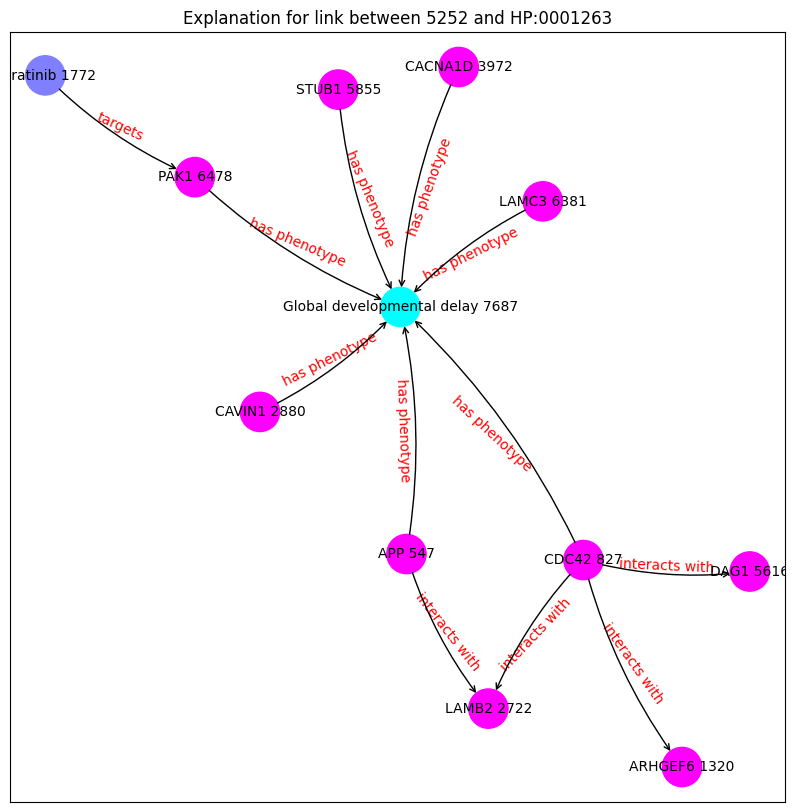

tensor([ 0,  2,  3,  4,  6,  8,  9, 10, 13, 16, 18, 19, 20, 22, 24])


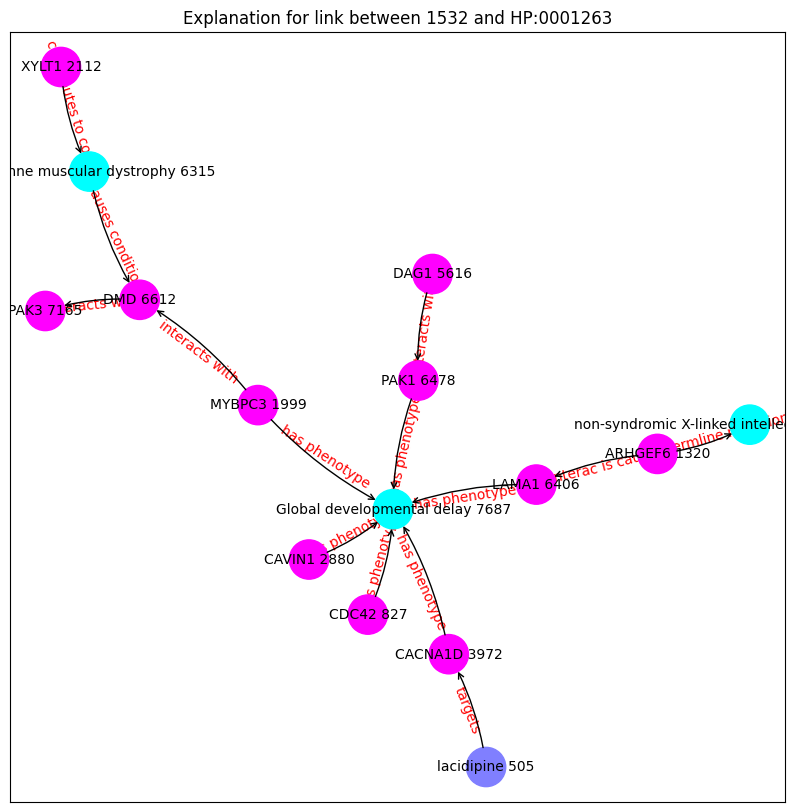

tensor([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11])


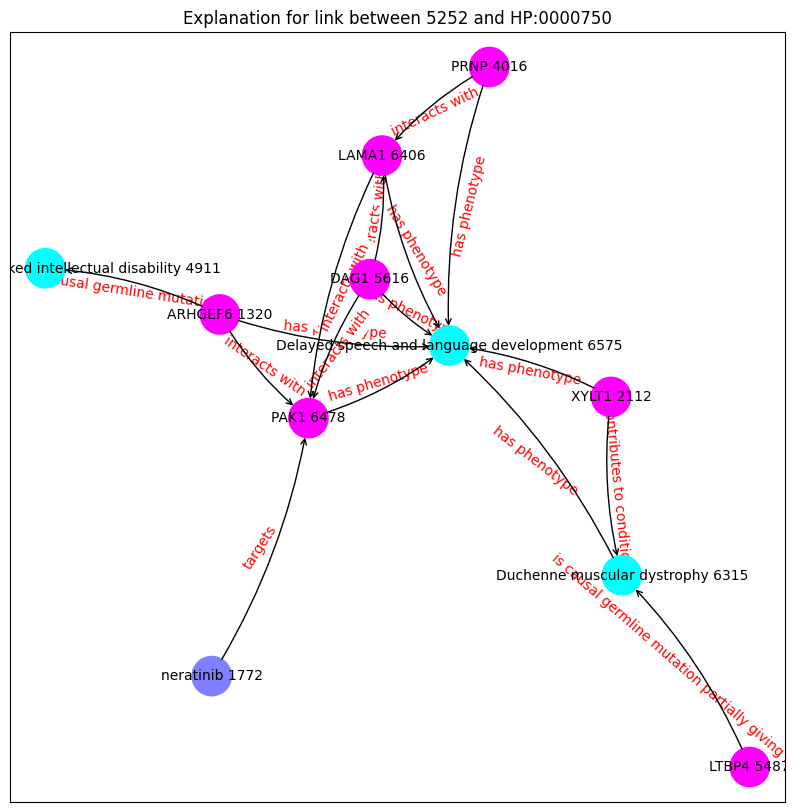

In [69]:
for i, explanation in enumerate(found_explanation):
    if explanation['found_limit'].count_nonzero():
        nodes_idxs = torch.Tensor([explanation['node_idx1'], explanation['node_idx2']]).long()

        plt.figure(figsize=(10, 10))
        plt.title(f"Explanation for link between {explanation['drug']} and {explanation['symptom']}")
        ax, G_sub = visualize_subgraph(nodes_idxs, edge_index, explanation['found_edge_mask'], nodes = nodes, y=torch.Tensor(nodes.semantic_id), seed = 667, num_hops = 1, threshold=explanation['found_limit'], node_label = 'label', edge_labels = edge_labels_dict, show_inactive = False, remove_unconnected = True)
        plt.show()

Really dependent on parameter of trained model.